In [2]:
import os 
cwd = os.getcwd()
sep = os.sep
loss_dir = cwd + sep + "train_losses"
tasks = ["denoising", "reconstruction", "inpainting", "anomaly detection"]
model_names = ["ae", "kae", "cae", "kcae", "cae-ps", "kcae-ps"]
dataset_name = "Stethoscope"
splits = ["train", "val"]

In [3]:
import matplotlib.pyplot as plt

for task in tasks:
    losses = {}
    for split in splits:
        losses[split] = {}
        for model_name in model_names:
            file_path = os.path.join(loss_dir, f"{model_name}{dataset_name}_{task}_{split}.txt")
            model_losses = []
            if os.path.exists(file_path):
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    model_losses = [float(line.split(":")[-1]) for line in lines if line.strip()]
            else:
                print(f"Warning: Loss file {file_path} does not exist.")
            losses[split][model_name] = model_losses
    """
    print(f"Losses for {task.capitalize()} Task:")
    for split, model_losses in losses.items():
        print(f"{split.capitalize()} losses:")
        for model_name, loss_values in model_losses.items():
            print(f"  {model_name}: {loss_values}")
    """
    # Plotting the losses
    plt.figure(figsize=(10, 6))
    for split, model_losses in losses.items():
        for model_name, loss_values in model_losses.items():
            plt.plot(loss_values, label=f"{model_name}")
        plt.title(f"{split} losses for {task.capitalize()} Task")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(os.path.join(loss_dir, f"{task}_losses_{split}.png"))
        plt.close()


In [39]:
from model_config import *
from utils import load_model
from models.cae import CAE
from models.kcae import KCAE
from models.ae import AutoEncoder
from models.kae import KAE

window_size = 4096
models = {
                #"ae": AutoEncoder(window_size, hidden_dims["linear"], dropout=dropout, bn=bn, act=act),
                #"kae": KAE(window_size, hidden_dims["linear_kan"], base_activation=act_kan_linear, dropout=dropout, bn=bn),
                #"cae": CAE(1, hidden_dims["conv"], kernel_sizes=kernel_sizes["conv"], strides=strides["conv"], paddings=paddings["conv"], act=act_conv, pixel_shuffle=False, dropout=0.0),
                #"kcae": KCAE(1, hidden_dims["conv_kan"], kernel_sizes=kernel_sizes["conv_kan"], strides=strides["conv_kan"], paddings=paddings["conv_kan"], base_activation=act_kan, dropout=0.0, pixel_shuffle=False),
                "cae-ps": CAE(1, hidden_dims["conv"], kernel_sizes=kernel_sizes["conv"], strides=strides["conv"], paddings=paddings["conv"], act=act_conv, pixel_shuffle=True, dropout=dropout),
                #"kcae-ps": KCAE(1, hidden_dims["conv_kan"], kernel_sizes=kernel_sizes["conv_kan"], strides=strides["conv_kan"], paddings=paddings["conv_kan"], base_activation=act_kan, pixel_shuffle=True, dropout=dropout),
}

In [40]:
models_task = {}
tasks = ["reconstruction", "denoising", "inpainting"]
if "generation" in tasks:
    tasks.remove("generation")  # Remove 'generation' task if it exists
for task in tasks:
    print(task)
    models_task[task] = {}
    for model_name, model in models.items():
        model_path = os.path.join(cwd, "models_ckpt", f"{model_name}_{dataset_name}_{task}.pt")
        if os.path.exists(model_path):
            model = load_model(model, model_path)
            model.eval()
            model.to(device)
            models_task[task][model_name] = model
            print(f"Model {model_name} loaded successfully.")
        else:
            print(f"Model file {model_path} does not exist. Skipping loading for {model_name}.")

reconstruction
Model cae-ps loaded successfully.
denoising
Model cae-ps loaded successfully.
inpainting
Model cae-ps loaded successfully.


In [41]:
from utils import add_noise_single, read_arff, split_windows

datapath = datapaths[dataset_name]["datapath"]
test_filename = datapaths[dataset_name]["test_filename"]

xs_test, ys_test = read_arff(datapath + sep + test_filename)
xs_test, ys_test = split_windows(xs_test, ys_test, window_size=window_size)
xs_test_clean = xs_test.clone()
xs_test_noisy = add_noise_single(xs_test, noise_level=noise_level, noise_prob=1.0)
xs_test_noisy.shape

torch.Size([820, 4096])

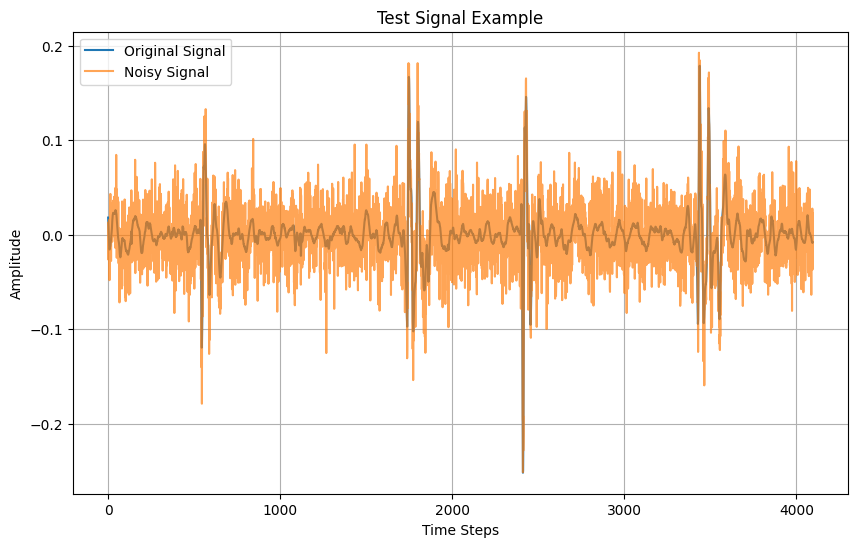

In [42]:
import random 
import matplotlib.pyplot as plt
idx = random.randint(0, xs_test.shape[0] - 1)
plt.figure(figsize=(10, 6))
plt.plot(xs_test_clean[idx], label='Original Signal')
plt.plot(xs_test_noisy[idx], label='Noisy Signal', alpha=0.7)
plt.title('Test Signal Example')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

In [43]:
from utils import mask_input
from model_config import * 
import random

xs_test_masked_noised, xs_test_masked_clean = mask_input(xs_test_clean, min_mask_size=min_mask_size, max_mask_size=max_mask_size, mask_prob=1.0, add_noise=True, noise_level=noise_level_mask)

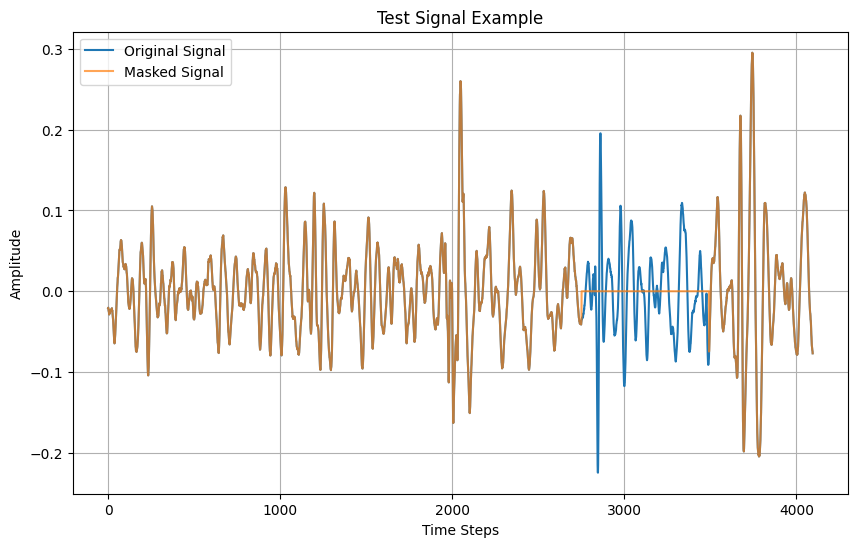

In [44]:
idx = random.randint(0, xs_test.shape[0] - 1)
plt.figure(figsize=(10, 6))
plt.plot(xs_test_clean[idx], label='Original Signal')
plt.plot(xs_test_masked_clean[idx], label='Masked Signal', alpha=0.7)
plt.title('Test Signal Example')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

In [45]:
from torch.nn.functional import mse_loss

def create_loss_dict(models, xs_test):
    losses = {}
    for model_name, model in models.items():
        losses[model_name] = []
        model.eval()
        model.to(device)
        for i, x in enumerate(xs_test):
            x = x.to(device)
            if x.ndim == 1:
                x = x.unsqueeze(0)
            if x.ndim == 2:
                x = x.unsqueeze(1)
            with torch.no_grad():
                rec = model(x)
            
            if rec.ndim == 1:
                rec = rec.unsqueeze(0)
            if rec.ndim == 2:
                rec = rec.unsqueeze(1)
                
            loss = mse_loss(rec, x)
            losses[model_name].append(loss.item())
    return losses

def get_best_idx(losses):

    best_idx = None
    best_loss = float('inf')
    for model_name, loss_values in losses.items():
        for idx, loss in enumerate(loss_values):   
            if loss < best_loss:
                best_loss = loss
                best_idx = idx
    return best_idx

In [46]:
models_task = {}
for task in tasks:
    print(f"Creating loss dictionary for task: {task}")
    if task == "denoising":
        xs = xs_test_noisy
    elif task == "inpainting":
        xs = xs_test_masked_noised
    else:
        xs = xs_test_clean
    models_task[task] = create_loss_dict(models, xs)

Creating loss dictionary for task: generation
Creating loss dictionary for task: reconstruction
Creating loss dictionary for task: anomaly detection
Creating loss dictionary for task: denoising
Creating loss dictionary for task: inpainting


In [47]:
from itertools import groupby

def find_longest_consecutive_indexes(indexes):
    if len(indexes) == 0:
        return []
    
    # Sort the indexes first
    sorted_indexes = sorted(set(indexes))
    
    # Group consecutive numbers
    groups = []
    for k, g in groupby(enumerate(sorted_indexes), lambda x: x[1] - x[0]):
        group = list(map(lambda x: x[1], g))
        groups.append(group)
    
    # Return the longest group
    return max(groups, key=len) if groups else []


In [48]:
def plot_reconstruction(models, xs_test, best_idx, task, xs_test_masked_clean=None, model_toplot = "cae"):
    
    fig = plt.figure(figsize=(10, 6))
    
    for model_name in models.keys():
        x = xs_test[best_idx].unsqueeze(0).to(device)
        if x.ndim == 1:
            x = x.unsqueeze(0)
        if x.ndim == 2:
            x = x.unsqueeze(1)
        rec = models[model_name](x).squeeze(0).squeeze(0)
        if "c" in model_name:
            linewidth = 1
            alpha = 1
        else:
            linewidth = 0.5
            alpha = 0.5
            
        if model_name == model_toplot or model_toplot is None:
            plt.plot(rec.cpu().detach().numpy(), label=f"{model_name}", alpha=alpha, linewidth=linewidth)

    if task == "inpainting":
        type = "Masked"
        linewidth = 1
        alpha = 1
    elif task == "denoising":
        type = "Noisy"
        alpha = 0.5
        linewidth = 0.5
    else:
        type = "Reconstructed"

    if xs_test_masked_clean is not None:
        plt.plot(xs_test_masked_clean[best_idx], label='Masked Signal', alpha=0.7, linewidth=linewidth)
    else:
        plt.plot(xs_test[best_idx], label=f'{type} Signal', linewidth=linewidth, alpha=0.3)
        
    plt.plot(xs_test_clean[best_idx], label='Original Signal', linewidth=1)


    if task == "inpainting":
        #plotting rectangle mask taken from xs_test_masked_clean[best_idx]
        zeros_idxs = (xs_test_masked_clean[best_idx] == 0).nonzero(as_tuple=True)[0]
        zeros_idxs = zeros_idxs.cpu().detach().numpy()
        zeros_idxs = find_longest_consecutive_indexes(zeros_idxs)
        start = zeros_idxs[0]
        end = zeros_idxs[-1]
        plt.axvspan(start, end, color='red', alpha=0.3, label='Masked Region')

    plt.title(f'{task.capitalize()} Example', fontsize=24, fontweight='bold')
    plt.xlabel('Time Steps', fontsize=18, fontweight='bold')
    plt.ylabel('Amplitude', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=16)
    plt.grid()
    plt.show()
    return fig 

Best index for denoising task: 67


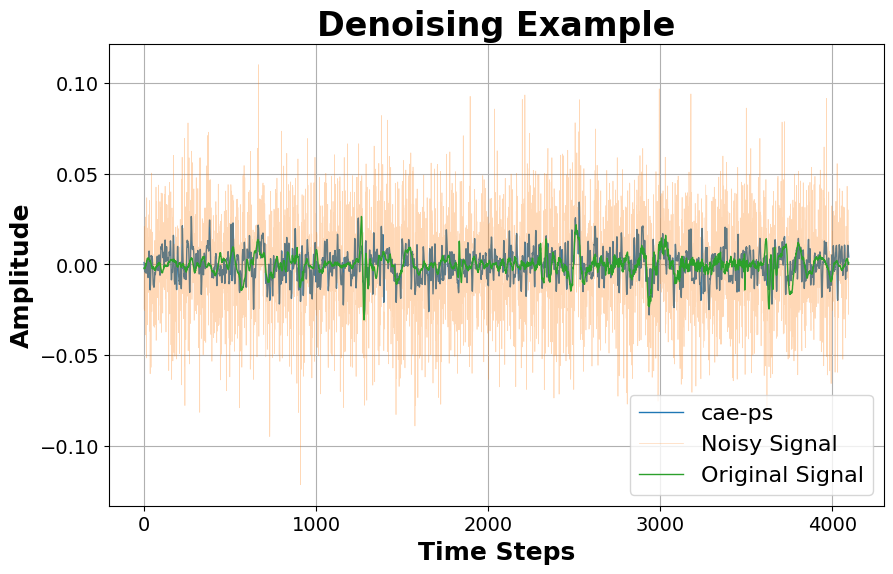

In [50]:
models_denoising = models_task["denoising"]
best_idx = get_best_idx(models_denoising)
print(f"Best index for denoising task: {best_idx}")
fig = plot_reconstruction(models, xs_test_noisy, best_idx, "denoising", model_toplot=None)

Index for inpainting task: 140


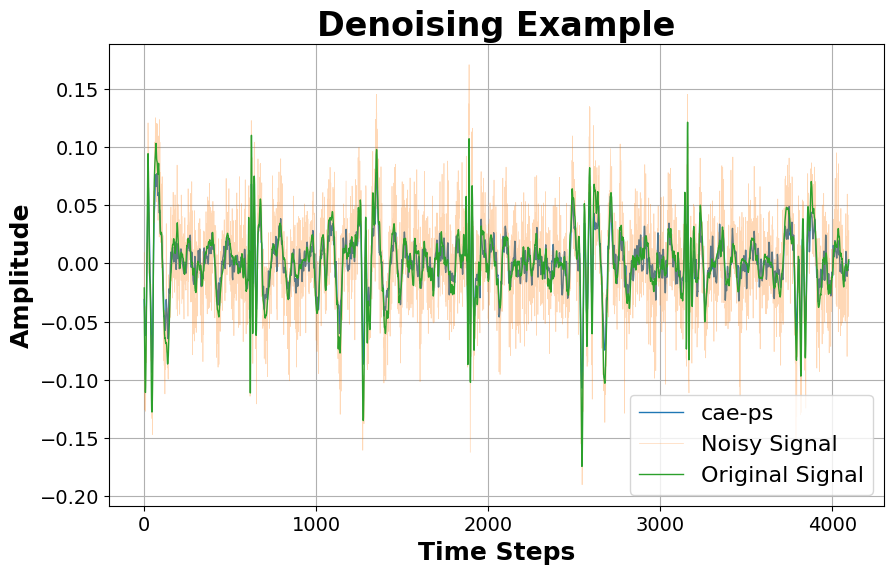

In [61]:
idx = random.randint(0, xs_test.shape[0] - 1)
print(f"Index for inpainting task: {idx}")
fig = plot_reconstruction(models, xs_test_noisy, idx, "denoising", model_toplot=None)

In [62]:
fig.savefig(cwd + sep + "denoising_example.png", bbox_inches='tight', dpi=600)

Index for inpainting task: 541


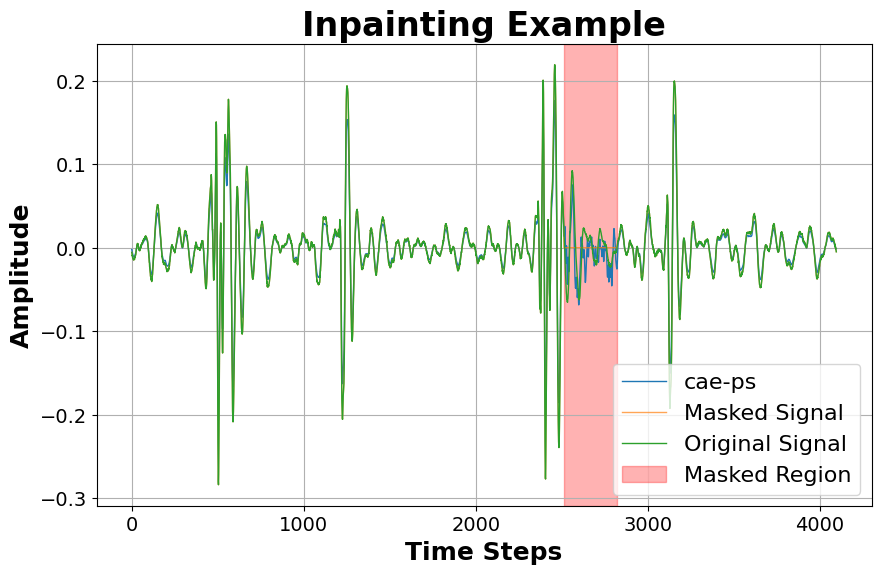

In [75]:
import random
idx = random.randint(0, xs_test.shape[0] - 1)
models_inpainting = models_task["inpainting"]
print(f"Index for inpainting task: {idx}")
fig = plot_reconstruction(models, xs_test_masked_noised, idx, "inpainting", xs_test_masked_clean=xs_test_masked_clean, model_toplot="cae-ps")

In [76]:
fig.savefig(cwd + sep + "inpainting_example.png", dpi = 600)

Index for reconstruction task: 592


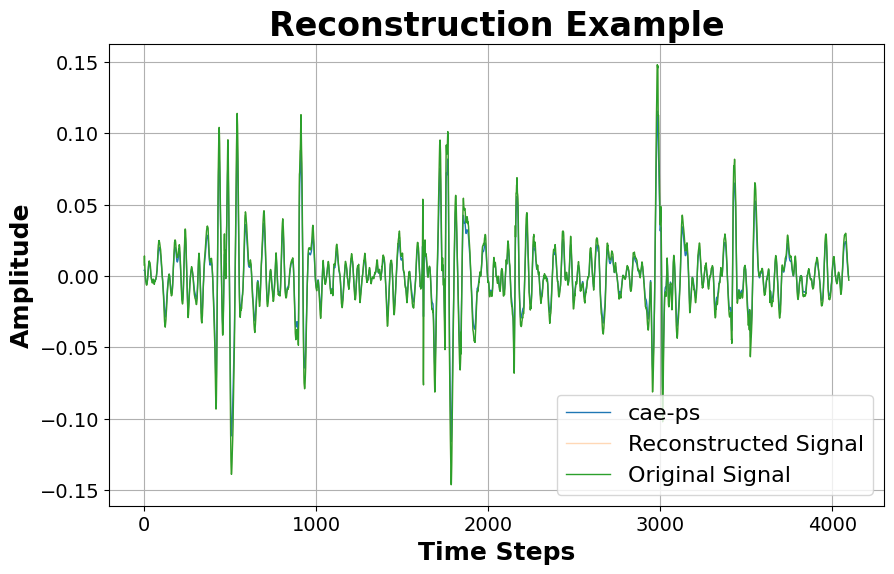

In [85]:
idx = random.randint(0, xs_test.shape[0] - 1)
models_inpainting = models_task["reconstruction"]
print(f"Index for reconstruction task: {idx}")
fig = plot_reconstruction(models, xs_test_clean, idx, "reconstruction", xs_test_masked_clean=None, model_toplot="cae-ps")

In [86]:
fig.savefig(cwd + sep + "reconstruction_example.png", dpi = 600)